# Racist Content Detection Experiement

In [86]:
!python -V

Python 3.10.13


In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import nltk
import nomic


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nomic import atlas
from nomic import embed
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [122]:
df = pd.read_csv('../data/tweets.csv', usecols=['Cleaned tweet', 'Tag'])
df.columns = ['text', 'label']
df_sample = df.sample(frac=0.5, random_state=42).reset_index(drop=True)
df_sample.head()

,text,label
0,People have the right to be wherever we want a...,0
1,"And meanwhile, in the Madrid neighborhood of E...",1
2,I hear my mom say “fucking black man” “no soul...,0
3,"You are wrong, bastard, you are just another i...",1
4,It's just that you see a black man with luxuri...,0


### Data Preprocessing

In [123]:
def remove_non_ascii(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

df_sample['text'] = df_sample['text'].apply(remove_non_ascii)
df_sample.head()

,text,label
0,People have the right to be wherever we want a...,0
1,"And meanwhile, in the Madrid neighborhood of E...",1
2,I hear my mom say fucking black man no soul sk...,0
3,"You are wrong, bastard, you are just another i...",1
4,It's just that you see a black man with luxuri...,0


In [124]:
missing_values = df_sample.isnull().sum()
label_dist = df_sample['label'].value_counts(normalize=True)

print("Missing Values:\n", missing_values)
print("Label Distribution:\n", label_dist)

Missing Values:
 text     0
label    0
dtype: int64
Label Distribution:
 label
0    0.509
1    0.491
Name: proportion, dtype: float64


### Exploratory Data Analysis

In [125]:
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

def calculate_word_frequencies(texts):
    words = []
    
    for text in texts:
        tokens = word_tokenize(text)
        filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
        words.extend(filtered_tokens)

    return Counter(words)

frequencies = calculate_word_frequencies(df_sample['text'])
frequencies.most_common(10)

[('immigrant', 475),
 ('boat', 140),
 ('menas', 118),
 ('country', 103),
 ('immigrants', 96),
 ('people', 94),
 ('one', 91),
 ('black', 89),
 ('like', 82),
 ('would', 80)]

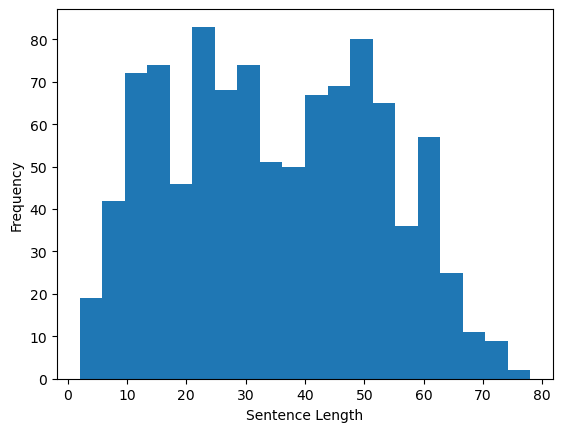

In [126]:
sentence_length = [len(word_tokenize(sentence)) for sentence in df_sample['text']]

plt.hist(sentence_length, bins=20)
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

### Feature Engineering

In [127]:
data = df_sample[['text']].to_dict(orient='records')
dataset = atlas.map_data(
    data=data,
    indexed_field='text',
)

2024-03-02 16:32:12.168 | WARNING  | nomic.atlas:map_data:96 - An ID field was not specified in your data so one was generated for you in insertion order.


2024-03-02 16:32:16.346 | INFO     | nomic.dataset:_create_project:868 - Creating dataset `disorganized-mcclintock`
2024-03-02 16:32:16.794 | INFO     | nomic.atlas:map_data:108 - Uploading data to Atlas.
1it [00:01,  1.05s/it]
2024-03-02 16:32:17.904 | INFO     | nomic.dataset:_add_data:1536 - Upload succeeded.
2024-03-02 16:32:17.907 | INFO     | nomic.atlas:map_data:123 - `veelangat/disorganized-mcclintock`: Data upload succeeded to dataset`
2024-03-02 16:32:20.136 | INFO     | nomic.dataset:create_index:1245 - Created map `disorganized-mcclintock` in dataset `veelangat/disorganized-mcclintock`: https://atlas.nomic.ai/data/veelangat/disorganized-mcclintock/map


In [137]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

tfidf_matrix = vectorizer.fit_transform(df_sample['text'])
feature_names = vectorizer.get_feature_names_out()

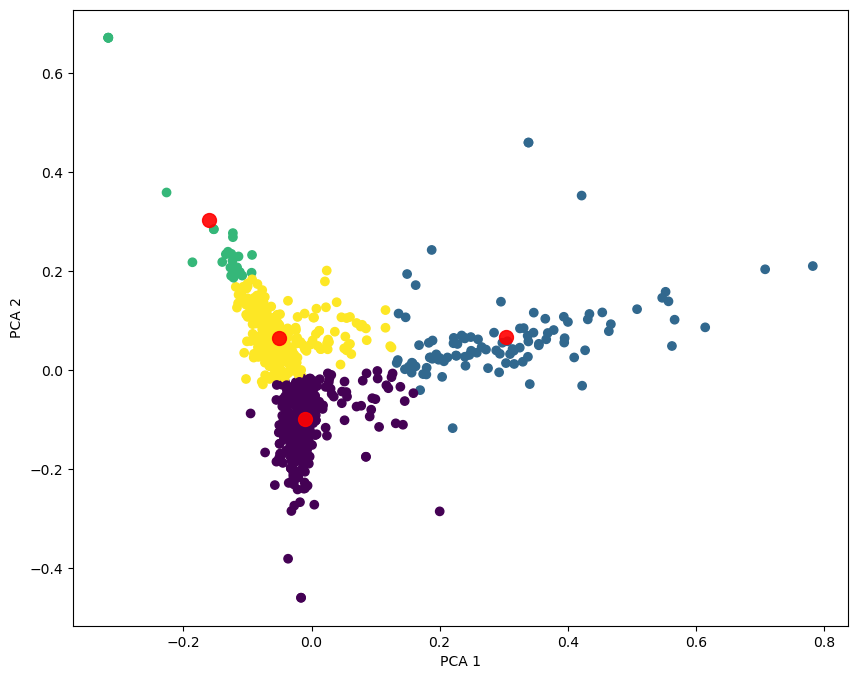

In [130]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_features)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.9)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [138]:
def tfidf_cluster_terms(tfidf_matrix, clusters, feature_names, n_terms=10):
    df = pd.DataFrame(tfidf_matrix.todense()).groupby(clusters).mean()
    
    for i, row in df.iterrows():
        print(f"Cluster {i}:")
        top_indices = row.argsort()[-n_terms:][::-1]
        top_terms = ", ".join([feature_names[index] for index in top_indices])
        print(top_terms)

tfidf_cluster_terms(tfidf_matrix, clusters, feature_names)


Cluster 0:
immigrant, country, don, illegal, time, man, immigrants, person, fucking, right
Cluster 1:
immigrant, immigrants, country, illegal, don, years, boat, people, spanish, going
Cluster 2:
menas, boat, spain, people, government, don, come, islands, spanish, like
Cluster 3:
black, fucking, shitty, panchito, shit, sudaca, man, don, say, moor


In [144]:
X_train, X_test, y_train, y_test = train_test_split( tfidf_matrix,  df_sample['label'], test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("Accuracy:", lr_model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       106
           1       0.74      0.71      0.73        94

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



In [154]:
output = embed.text(
    texts=df_sample['text'].tolist(),
    model='nomic-embed-text-v1',
)

print(output['usage'])

embeddings = np.array(output['embeddings'])

print(embeddings.shape)

{'prompt_tokens': 38080, 'total_tokens': 38080}
(1000, 768)


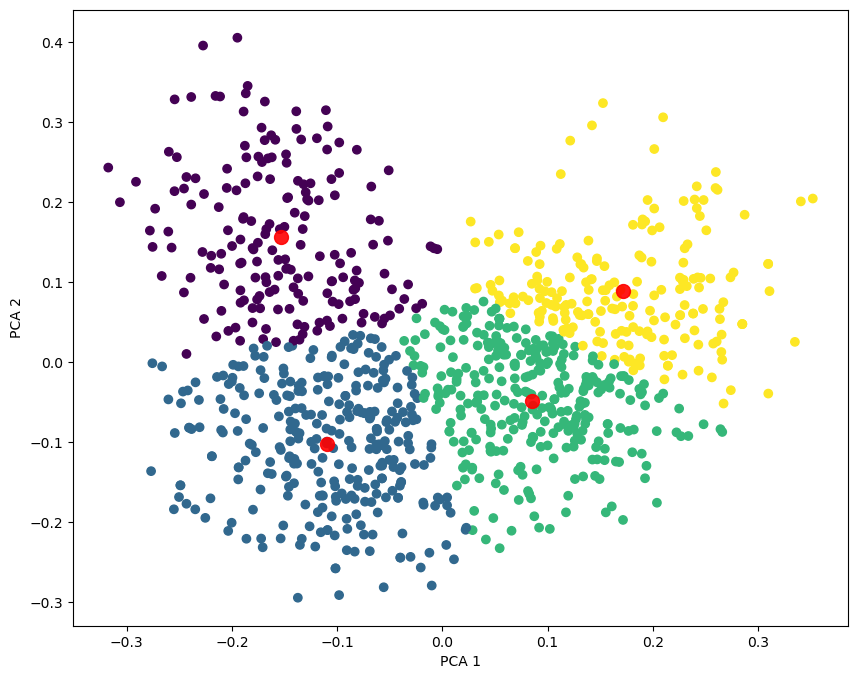

In [146]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(embeddings)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_features)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.9)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [155]:
df_sample['cluster'] = clusters

def nomic_cluster_terms(n_terms=10):
    df = df_sample.groupby('cluster')['text'].apply(list).reset_index()
    top_terms = {}

    for cluster in df['cluster']:
        texts = df[df['cluster'] == cluster]['text'].iloc[0]
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(texts)
        feature_array = np.array(vectorizer.get_feature_names_out())
        tfidf_sorting = np.argsort(tfidf_matrix.toarray()).flatten()[::-1]
        
        top_n = feature_array[tfidf_sorting][:n_terms]
        top_terms[cluster] = top_n
        
    return top_terms

top_words = nomic_cluster_terms(n_terms=10)
for cluster, words in top_words.items():
    print(f"Cluster {cluster}:\n{', '.join(words)}")

Cluster 0:
lot, deaf, support, palacios, individual, imbalance, castro, middle, flimsy, hurting
Cluster 1:
century, new, lottery, aztec, mexican, printed, emerges, land, allusion, tradition
Cluster 2:
blacks, branded, fined, untouchable, east, middle, africa, muslims, figure, prison
Cluster 3:
host, scammer, family, country, immigrant, film, feelings, felt, fields, fight


In [156]:
X_train, X_test, y_train, y_test = train_test_split(embeddings,  df_sample['label'], test_size=0.2, random_state=42)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("Accuracy:", lr_model.score(X_test, y_test))
print(classification_report(y_test, y_pred))

Accuracy: 0.785
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       106
           1       0.76      0.79      0.77        94

    accuracy                           0.79       200
   macro avg       0.78      0.79      0.78       200
weighted avg       0.79      0.79      0.79       200



In [166]:
param_grid = {
    'n_estimators': [200, 400, 600], 
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10, 15],  
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  12.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   6.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=  12.7s
[CV] END m

In [168]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.765
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       106
           1       0.76      0.73      0.75        94

    accuracy                           0.77       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.76      0.77      0.76       200

